# Inference on nuScenes mini dataset

In [1]:
import os
import copy
import glob
import torch
import random
import numpy as np
from tqdm import tqdm

from det3d import torchie
from det3d.datasets import build_dataloader, build_dataset
from det3d.models import build_detector
from det3d.torchie import Config
from det3d.torchie.apis import (
    batch_processor,
    build_optimizer,
    get_root_logger,
    init_dist,
    set_random_seed,
    train_detector,
)
from det3d.torchie.trainer import get_dist_info, load_checkpoint
from det3d.torchie.trainer.utils import all_gather, synchronize
from tools.demo_utils import visual

os.environ["CUDA_VISIBLE_DEVICES"] = '3'

no apex
No Tensorflow
Deformable Convolution not built!
No APEX!


In [2]:
work_dir = 'work_dirs/centerpoint_pillar_pretrain/demo-mini'
trt_work_dir = os.path.join(work_dir, 'tensorrt')
onnx_work_dir = os.path.join(work_dir, 'onnx')
os.makedirs(work_dir, exist_ok=True)
os.makedirs(trt_work_dir, exist_ok=True)
os.makedirs(onnx_work_dir, exist_ok=True)

cfg = Config.fromfile('configs/nusc/pp/nusc_centerpoint_pp_02voxel_two_pfn_10sweep_mini.py')

model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
checkpoint = load_checkpoint(model, 'work_dirs/centerpoint_pillar_pretrain/latest.pth', map_location="cpu")
model = model.cuda()
model.eval()

dataset = build_dataset(cfg.data.val)
data_loader = build_dataloader(
    dataset,
    batch_size=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False,
)

def convert_box(info):
    boxes =  info["gt_boxes"].astype(np.float32)
    names = info["gt_names"]
    assert len(boxes) == len(names)
    detection = {}
    detection['box3d_lidar'] = boxes
    # dummy value 
    detection['label_preds'] = np.zeros(len(boxes)) 
    detection['scores'] = np.ones(len(boxes))
    return detection

Use HM Bias:  -2.19
10


## PyTorch Model

### prepare data

In [ ]:
points_dict = {}
gt_annos_dict = {}

for i, data in tqdm(enumerate(dataset), total=len(dataset)):
    token = data['metadata']['token']
    # points_list for visualization
    points = data['points'][:, :3]
    points_dict[token] = points.T
    # gt_annos for visualization
    info = dataset._nusc_infos[i]
    gt_annos = convert_box(info)
    gt_annos_dict[token] = gt_annos

100%|██████████| 81/81 [00:11<00:00,  7.31it/s]


### inference

In [ ]:
token_list = []
detections = {}

for i, data_batch in tqdm(enumerate(data_loader), total=len(data_loader.dataset)):
    with torch.no_grad():
        outputs = batch_processor(
            model, data_batch, train_mode=False, local_rank=0
        )
    for output in outputs:
        token = output["metadata"]["token"]
        token_list.append(token)
        for k, v in output.items():
            if k not in [
                "metadata",
            ]:
                output[k] = v.to(torch.device("cpu"))
        detections.update(
            {token: output,}
        )

100%|██████████| 81/81 [00:09<00:00,  8.95it/s]


### visualization

b22fa0b3c34f47b6a360b60f35d5d567


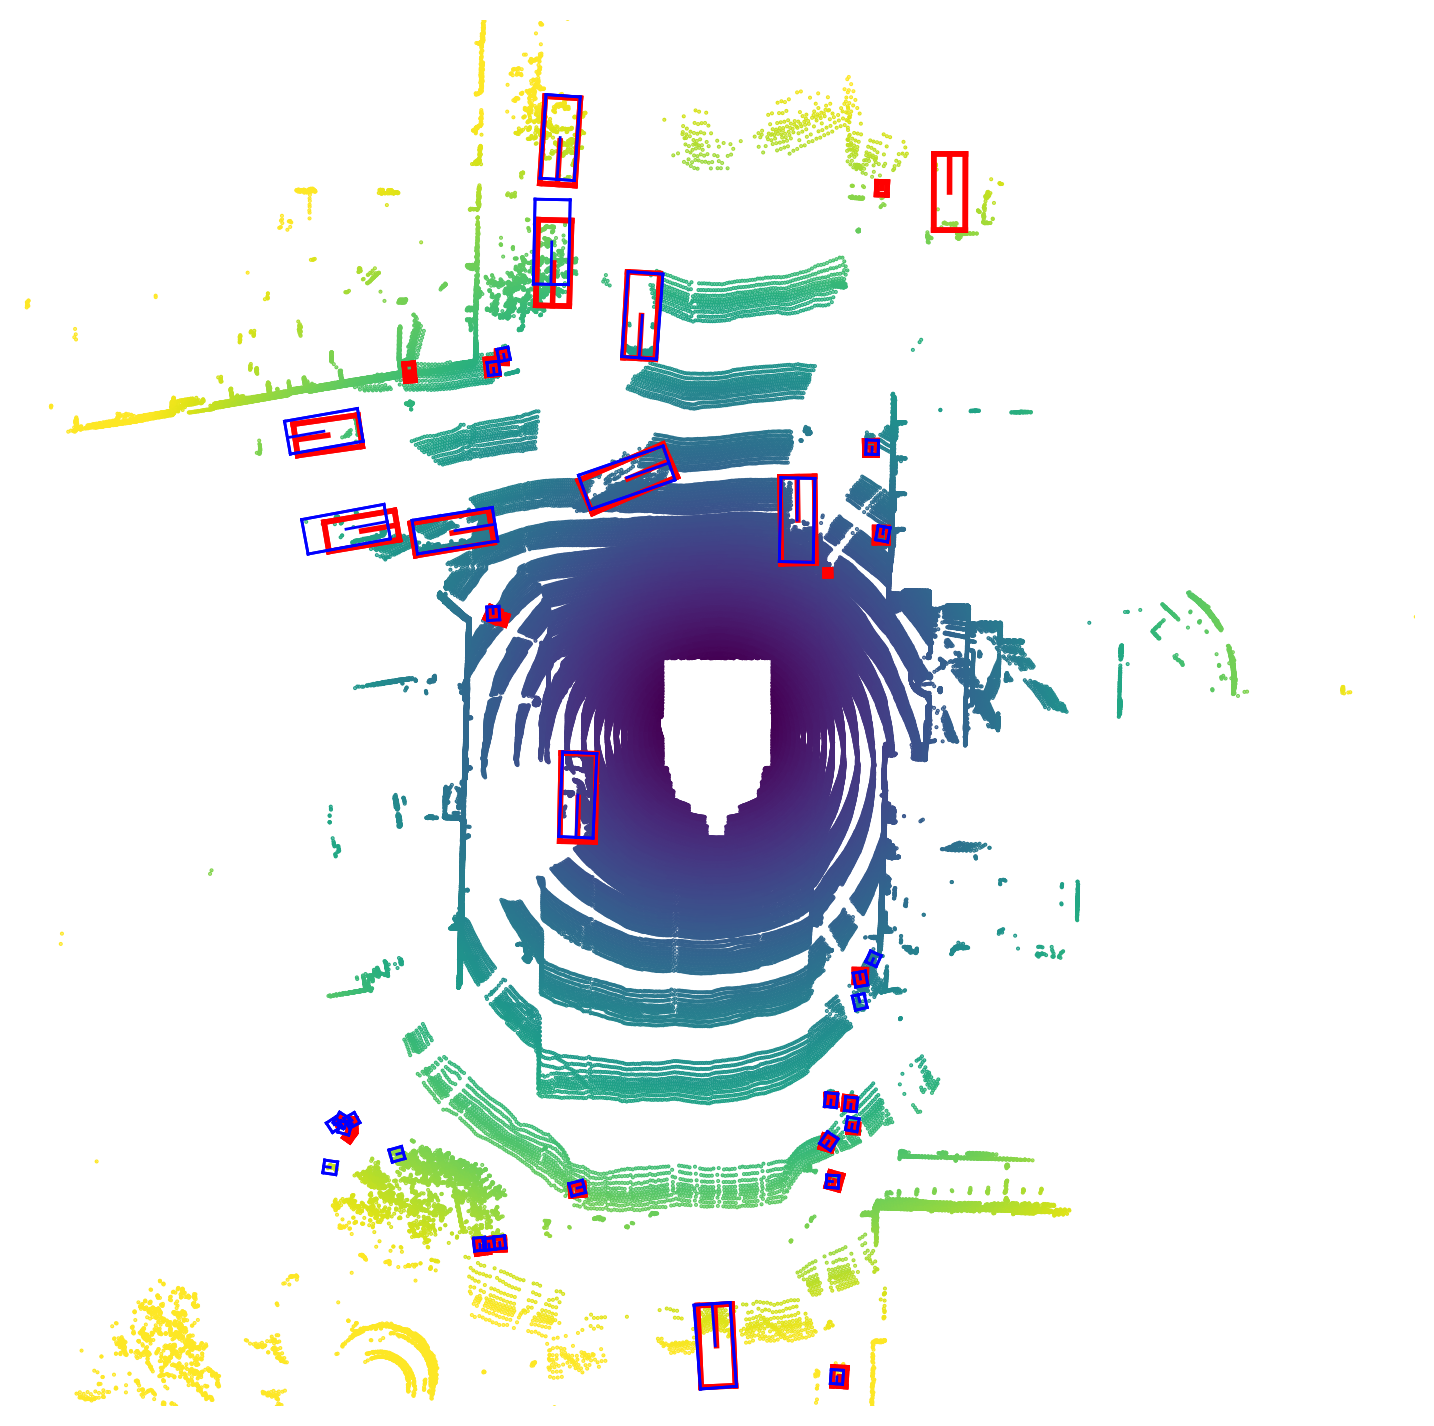

In [ ]:
vis_num = 1
draw_num = min(vis_num, len(token_list))
save_path = os.path.join(work_dir, "visual")
for token in random.sample(token_list, draw_num):
    print(token)
    visual(
        copy.deepcopy(points_dict[token]),
        copy.deepcopy(gt_annos_dict[token]),
        copy.deepcopy(detections[token]),
        token, save_path=None
    )

### evaluation

In [ ]:
all_predictions = all_gather(detections)

predictions = {}
for p in all_predictions:
    predictions.update(p)

result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.7 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/demo-mini/infos_val_10sweeps_withvelo_filter_True.json
Initializing nuScenes detection evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/demo-mini/infos_val_10sweeps_withvelo_filter_True.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 286.64it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 17662
=> After distance based filtering: 14563
=> After LIDAR points based filtering: 14563
=> After bike rack filtering: 14496
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Rendering sample token b6c420c3a5bd4a219b1cb82ee5ea0aa7
Rendering sample token b22fa0b3c34f47b6a360b60f35d5d567
Rendering sample token d8251bbc2105497ab8ec80827d4429aa
Rendering sample token 372725a4b00e49c78d6d0b1c4a38b6e0
Rendering sample token ce94ef7a0522468e81c0e2b3a2f1e12d
Rendering sample token 0d0700a2284e477db876c3ee1d864668
Rendering sample token 61a7bd24f88a46c2963280d8b13ac675
Rendering sample token fa65a298c01f44e7a182bbf9e5fe3697
Rendering sample token 8573a885a7cb41d185c05029eeb9a54e
Rendering sample token 38a28a3aaf2647f2a8c0e90e31267bf8
Accumulating metric data.

## TensorRT Results

### prepare data

In [ ]:
trt_data_dir = "tensorrt/data/centerpoint/points"
os.makedirs(trt_data_dir, exist_ok=True)

points_dict = {}
gt_annos_dict = {}

for i, data in tqdm(enumerate(dataset), total=len(dataset)):
    token = data['metadata']['token']
    # save points for TensorRT
    data["points"].astype(np.float32).tofile(
        os.path.join(trt_data_dir, f"{token}.bin")
    )
    # points_list for visualization
    points = data['points'][:, :3]
    points_dict[token] = points.T
    # gt_annos for visualization
    info = dataset._nusc_infos[i]
    gt_annos = convert_box(info)
    gt_annos_dict[token] = gt_annos

100%|██████████| 81/81 [00:10<00:00,  7.99it/s]


### inference

- run docker: `shell_scripts/tensorrt_docker.sh`
    - make: `tensorrt/samples/centerpoint`
    - execute: `tensorrt/bin/centerpoint`

### collect results

In [ ]:
trt_res_list = glob.glob("tensorrt/data/centerpoint/results/*.txt")

detections = {}
token_list = []

def read_trt_result(path):
    trt_pred = {}
    token = path.split("/")[-1].split(".")[0]

    box3d = []
    score = []
    cls = []
    with open(path) as f:
        trt_res = f.readlines()
    for line in trt_res:
        box3d += [np.array([float(it) for it in line.strip().split(" ")[:9]])]
        score += [np.array([float(line.strip().split(" ")[-2])])]
        cls += [np.array([int(line.strip().split(" ")[-1])])]

    trt_pred["box3d_lidar"] = torch.from_numpy(np.array(box3d))
    trt_pred["scores"] = torch.from_numpy(np.array(score))
    trt_pred["label_preds"] = torch.from_numpy(np.array(cls,np.int32))
    trt_pred["metadata"] = {}
    trt_pred["metadata"]["num_point_features"] = 5
    trt_pred["metadata"]["token"] = token
    
    return trt_pred, token

for path in tqdm(trt_res_list):
    output, token = read_trt_result(path)
    token_list.append(token)
    for k, v in output.items():
        if k not in [
            "metadata",
        ]:
            output[k] = v
    detections.update(
        {token: output,}
    )

100%|██████████| 81/81 [00:00<00:00, 482.40it/s]


### visualization

5b7cb170eee6468aa1fdbd3abcf63c5a


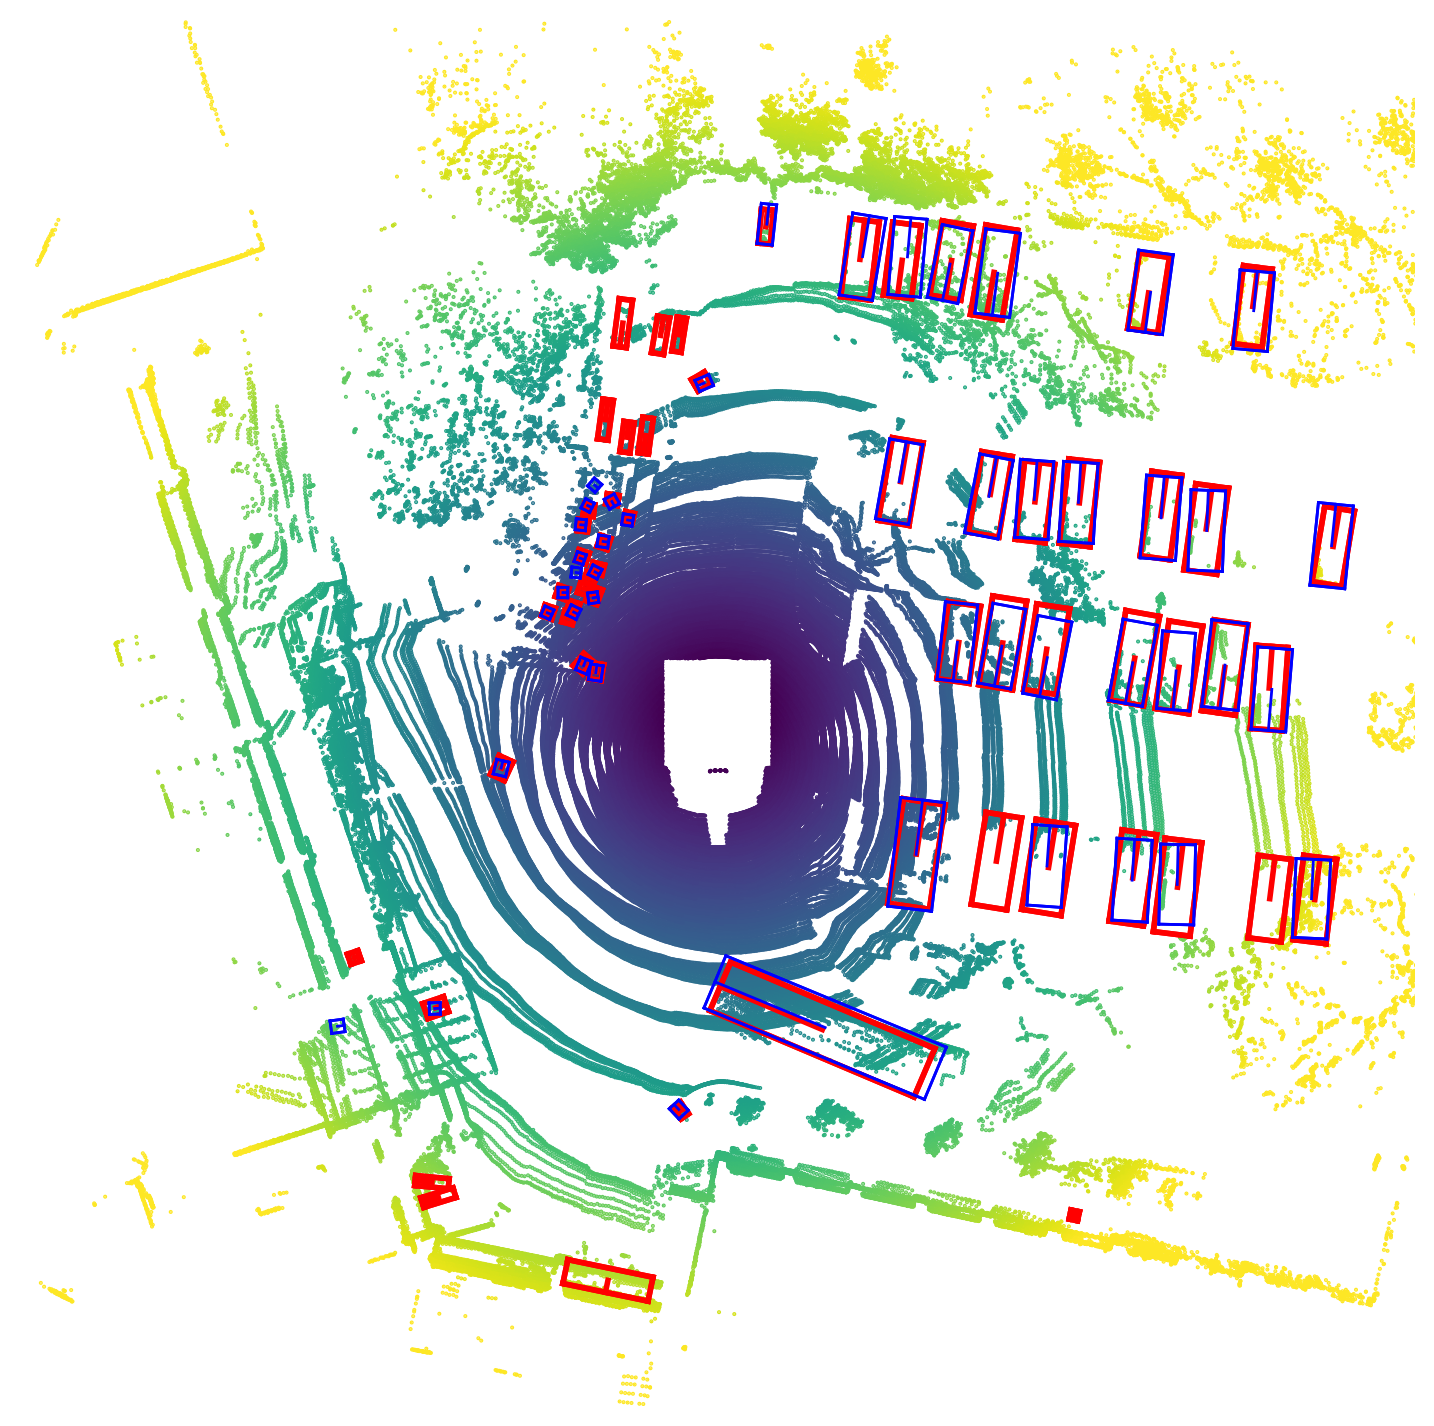

In [ ]:
vis_num = 1
draw_num = min(vis_num, len(token_list))
save_path = os.path.join(trt_work_dir, "visual")
for token in random.sample(token_list, draw_num):
    print(token)
    visual(
        copy.deepcopy(points_dict[token]),
        copy.deepcopy(gt_annos_dict[token]),
        copy.deepcopy(detections[token]),
        token, save_path=None
    )

### evaluation

In [ ]:
all_predictions = all_gather(detections)

predictions = {}
for p in all_predictions:
    predictions.update(p)

result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=trt_work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/demo-mini/tensorrt/infos_val_10sweeps_withvelo_filter_True.json
Initializing nuScenes detection evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/demo-mini/tensorrt/infos_val_10sweeps_withvelo_filter_True.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 289.82it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 15856
=> After distance based filtering: 12926
=> After LIDAR points based filtering: 12926
=> After bike rack filtering: 12861
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Rendering sample token b6c420c3a5bd4a219b1cb82ee5ea0aa7
Rendering sample token b22fa0b3c34f47b6a360b60f35d5d567
Rendering sample token d8251bbc2105497ab8ec80827d4429aa
Rendering sample token 372725a4b00e49c78d6d0b1c4a38b6e0
Rendering sample token ce94ef7a0522468e81c0e2b3a2f1e12d
Rendering sample token 0d0700a2284e477db876c3ee1d864668
Rendering sample token 61a7bd24f88a46c2963280d8b13ac675
Rendering sample token fa65a298c01f44e7a182bbf9e5fe3697
Rendering sample token 8573a885a7cb41d185c05029eeb9a54e
Rendering sample token 38a28a3aaf2647f2a8c0e90e31267bf8
Accumulating metric data.

## Onnx Model

### prepare data

In [ ]:
onnx_data_dir = os.path.join(onnx_work_dir, "data")
os.makedirs(onnx_data_dir, exist_ok=True)

points_dict = {}
gt_annos_dict = {}

for i, data in tqdm(enumerate(dataset), total=len(dataset)):
    token = data['metadata']['token']
    # points_list for visualization
    points = data['points'][:, :3]
    points_dict[token] = points.T
    # gt_annos for visualization
    info = dataset._nusc_infos[i]
    gt_annos = convert_box(info)
    gt_annos_dict[token] = gt_annos    
    # save points & gt for onnx
    np.savez(
        os.path.join(onnx_data_dir, f"{token}.npz"),
        points=data["points"].astype(np.float32),
        gt_annos=gt_annos
    )

100%|██████████| 81/81 [00:09<00:00,  8.37it/s]


### params

In [ ]:
FEATURE_NUM = 10
MAX_PILLARS = 30000
MAX_PIONT_IN_PILLARS = 20
BEV_W = 512
BEV_H = 512
OUTPUT_W = 128
OUTPUT_H = 128

X_MIN = -51.2
X_MAX = 51.2
Y_MIN = -51.2
Y_MAX = 51.2
Z_MIN = -5.0
Z_MAX = 3.0
X_STEP = 0.2
Y_STEP = 0.2

TASK_NUM = 6
SCORE_THREAHOLD = 0.1
OUT_SIZE_FACTOR = 4.0

NMS_PRE_MAX_SIZE = 1000
NMS_POST_MAX_SIZE = 83
NMS_THREAHOLD = 0.2

### preprocess & postprocess

In [ ]:
def read_inputs(token):
    featureFile = f"tensorrt/data/centerpoint/feature/{token}.bin.txt"
    indicesFile = f"tensorrt/data/centerpoint/indices/{token}.bin.txt"

    with open(featureFile) as f:
        line = f.readline()
        feature = np.array([float(it) for it in line.strip().split(" ")]).reshape(
            (1, FEATURE_NUM, MAX_PILLARS, MAX_PIONT_IN_PILLARS)
        ).astype(np.float32)
    
    with open(indicesFile) as f:
        line = f.readline()
        indices = np.array([float(it) for it in line.strip().split(" ")]).reshape(
            (1, MAX_PILLARS, 2)
        ).astype(np.int64)

    return feature, indices


def preprocess(points):
    """
    Preprocess lidar points into avilable model inputs.
    
    :params
        points: np.ndarray, [num_points, dim==5]
    :return
        feature: np.ndarray, [dim==10, num_pillars, num_points_per_pillar]
        indices: np.ndarray, [num_pillars, 2]
    """
    feature = np.zeros((FEATURE_NUM, MAX_PILLARS, MAX_PIONT_IN_PILLARS), dtype=np.float32)
    indices = np.zeros((MAX_PILLARS, 2), dtype=np.int64)
    
    # delete points out of range
    range_mask = \
        (points[:, 0]>X_MIN)*(points[:, 0]<X_MAX) * \
        (points[:, 1]>Y_MIN)*(points[:, 1]<Y_MAX) * \
        (points[:, 2]>Z_MIN)*(points[:, 2]<Z_MAX)
    points = points[range_mask]
    
    # get pillars by BEV idx
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    xIdx = ((x-X_MIN)/X_STEP).astype(np.int64)
    yIdx = ((y-Y_MIN)/Y_STEP).astype(np.int64)
    pillarIdx = yIdx*BEV_W + xIdx
    argsort_pillarIdx = pillarIdx.argsort()
    points = points[argsort_pillarIdx]
    pillarIdx = pillarIdx[argsort_pillarIdx]
    _, pointIdx = np.unique(pillarIdx, return_index=True)
    pillars = np.array(np.split(points, pointIdx[1:]), dtype=object)
    
    # sort pillars by number of points
    pointNum = np.array([pillar.shape[0] for pillar in pillars])
    argsort_pointNum = (-pointNum).argsort()
    pillars = pillars[argsort_pointNum][:MAX_PILLARS]
    pointNum = np.minimum(pointNum[argsort_pointNum][:MAX_PILLARS], MAX_PIONT_IN_PILLARS)
    pointCount = np.zeros((MAX_PILLARS), dtype=np.int64)
    pointCount[:pointNum.shape[0]] = pointNum
    
    # compute model inputs
    for i, pillar in enumerate(pillars):
        pillar_points = pillar[:MAX_PIONT_IN_PILLARS]
        num_points = pointCount[i]
        
        x, y = pillar_points[:, 0], pillar_points[:, 1]
        xIdx = ((x-X_MIN)/X_STEP).astype(np.int64)
        yIdx = ((y-Y_MIN)/Y_STEP).astype(np.int64)
        pillarIdx = yIdx*BEV_W + xIdx
        indices[i, 1] = pillarIdx[0]
        
        feature[:5, i, :num_points] = pillar_points.transpose((1,0))
        feature[8, i, :num_points] = x - (xIdx*X_STEP + X_MIN + X_STEP/2)
        feature[9, i, :num_points] = y - (yIdx*Y_STEP + Y_MIN + Y_STEP/2)
        
    valid_mask = np.arange(MAX_PIONT_IN_PILLARS)[None] < pointCount[:, None]
    centers = (feature[:3] * valid_mask).sum(-1, keepdims=True) / (valid_mask.sum(-1, keepdims=True)+1e-5)
    feature[5:8] = feature[:3] - centers
    feature *= valid_mask

    return feature[None], indices[None]


In [ ]:
def _rotate_around_center(x, y, cx, cy, theta):
    cos = np.cos(theta)
    sin = np.sin(theta)
    new_x = cx + (x-cx)*cos - (y-cy)*sin
    new_y = cy + (x-cx)*sin + (y-cy)*cos
    return new_x, new_y

def _get_bev_box(box):
    x, y, w, l, theta = \
        box[:, 0], box[:, 1], box[:, 3], box[:, 4], box[:, -1]
    x1, x2 = x - w/2, x + w/2
    y1, y2 = y - l/2, y + l/2
    corners = np.array(
        [[x1, y1], [x1, y2],
         [x2, y1], [x2, y2]]
    )
    
    bev_boxes = np.zeros((corners.shape[-1], 4, 2))
    for i, cor in enumerate(corners):
        bev_boxes[:, i, 0], bev_boxes[:, i, 1] = \
            _rotate_around_center(cor[0], cor[1], x, y, -theta)
    
    return bev_boxes


def aligned_IoU_BEV(box_q, box_seq):
    max_q, min_q = box_q.max(-2), box_q.min(-2)
    max_seq, min_seq = box_seq.max(-2), box_seq.min(-2)
    
    sArea_q = (max_q[0] - min_q[0]) * (max_q[1] - min_q[1])
    sArea_seq = (max_seq[:, 0] - min_seq[:, 0]) * (max_seq[:, 1] - min_seq[:, 1])
    
    sInter_w = np.minimum(max_q[0], max_seq[:, 0]) - np.maximum(min_q[0], min_seq[:, 0])
    sInter_h = np.minimum(max_q[1], max_seq[:, 1]) - np.maximum(min_q[1], min_seq[:, 1])
    
    sInter = np.maximum(sInter_w, 0.0) * np.maximum(sInter_h, 0.0)
    sUnion = sArea_q + sArea_seq - sInter
    
    IoU = sInter / sUnion
    
    return IoU

def aligned_NMS_BEV(box_feature, box_score):
    select_idx = []
    
    bev_boxes = _get_bev_box(box_feature)
    order = (-box_score).argsort()
    order = order[:NMS_PRE_MAX_SIZE]
    
    while len(order) > 0:
        i = order[0]
        select_idx.append(i)
        if len(order) == 1:
            break
        iou = aligned_IoU_BEV(bev_boxes[i], bev_boxes[order[1:]])
        idx = (iou < NMS_THREAHOLD).nonzero()[0]
        if len(idx) == 0:
            break
        order = order[idx+1]
    select_idx = select_idx[:NMS_POST_MAX_SIZE]
    
    return select_idx


def postprocess(ort_outputs):
    """
    refer to det3d/models/bbox_heads/center_head.py
    """
    regName = ["594", "618", "642", "666", "690", "714"]
    heightName = ["598", "622", "646", "670", "694", "718"]
    rotName = ["606", "630", "654", "678", "702", "726"]
    velName = ["610", "634", "658", "682", "706", "730"]
    dimName = ["736", "738", "740", "742", "744", "746"]
    hmName = ["735", "737", "739", "741", "743", "745"]
    clsOffsetPerTask = [0, 1, 3, 5, 6, 8]
    
    final_outputs = {
        "box3d_lidar": [],
        "scores": [],
        "label_preds": []
    }
    
    for taskIdx in range(TASK_NUM):
        reg = ort_outputs[regName[taskIdx]][0]
        height = ort_outputs[heightName[taskIdx]][0]
        rot = ort_outputs[rotName[taskIdx]][0]
        vel = ort_outputs[velName[taskIdx]][0]
        dim = ort_outputs[dimName[taskIdx]][0]
        hm = ort_outputs[hmName[taskIdx]][0]
        score = np.max(hm, axis=0)
        cls = np.argmax(hm, axis=0)

        xIdx = np.arange(OUTPUT_W)[None]
        yIdx = np.arange(OUTPUT_H)[:, None]
        x = (xIdx + reg[0])*OUT_SIZE_FACTOR*X_STEP + X_MIN
        y = (yIdx + reg[1])*OUT_SIZE_FACTOR*Y_STEP + Y_MIN
        
        score_mask = (score > SCORE_THREAHOLD)
        range_mask = \
            (x>X_MIN)*(x<X_MAX)* \
            (y>Y_MIN)*(y<Y_MAX)* \
            (height[0]>Z_MIN)*(height[0]<Z_MAX)
        valid_mask = score_mask * range_mask
        
        theta = np.arctan2(rot[0], rot[1])[None]
        box_feature = np.concatenate(
            [x[None], y[None], height, dim, vel, theta], axis=0
        ).transpose((1, 2, 0))
        box_feature = box_feature[valid_mask]
        box_score = score[valid_mask]
        box_cls = cls[valid_mask] + clsOffsetPerTask[taskIdx]
        
        select_idx = aligned_NMS_BEV(
            copy.deepcopy(box_feature),
            copy.deepcopy(box_score)
        )
        
        final_outputs["box3d_lidar"].append(box_feature[select_idx])
        final_outputs["scores"].append(box_score[select_idx])
        final_outputs["label_preds"].append(box_cls[select_idx])
        
    for k, v in final_outputs.items():
        final_outputs[k] = torch.from_numpy(np.concatenate(v, axis=0))

    return final_outputs


### inference

In [ ]:
import onnxruntime

onnx_model = 'work_dirs/centerpoint_pillar_pretrain/onnx/MatMul_Max_om/centerpoint.onnx'
ort_session = onnxruntime.InferenceSession(
    onnx_model,
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)

onnx_data_list = glob.glob(os.path.join(onnx_data_dir, "*.npz"))

token_list = []
detections = {}
points_dict = {}
gt_annos_dict = {}

for path in tqdm(onnx_data_list):
    token = path.split("/")[-1].split(".")[0]
    token_list.append(token)
    
    data = np.load(path, allow_pickle=True)
    points = data["points"]
    gt_annos = data["gt_annos"]
    
    feature, indices = preprocess(points)
    # feature, indices = read_inputs(token) # debug preprocess
    ort_inputs = {"input.1": feature, "indices_input": indices}
    
    output_names = [output.name for output in ort_session.get_outputs()]
    ort_outputs = ort_session.run(output_names, ort_inputs)
    ort_outputs = dict(zip(output_names, ort_outputs))
    
    final_outputs = postprocess(ort_outputs)
    final_outputs["metadata"] = {
        "token": token,
        "num_point_features": 5
    }
    
    detections.update({token: final_outputs})
    points_dict.update({token: points[:, :3].T})
    gt_annos_dict.update({token: gt_annos.item()})

2023-03-25 18:37:02.619249446 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'axes'. It is not used by any node and should be removed from the model.
100%|██████████| 81/81 [01:00<00:00,  1.34it/s]


### visualization

0bb62a68055249e381b039bf54b0ccf8


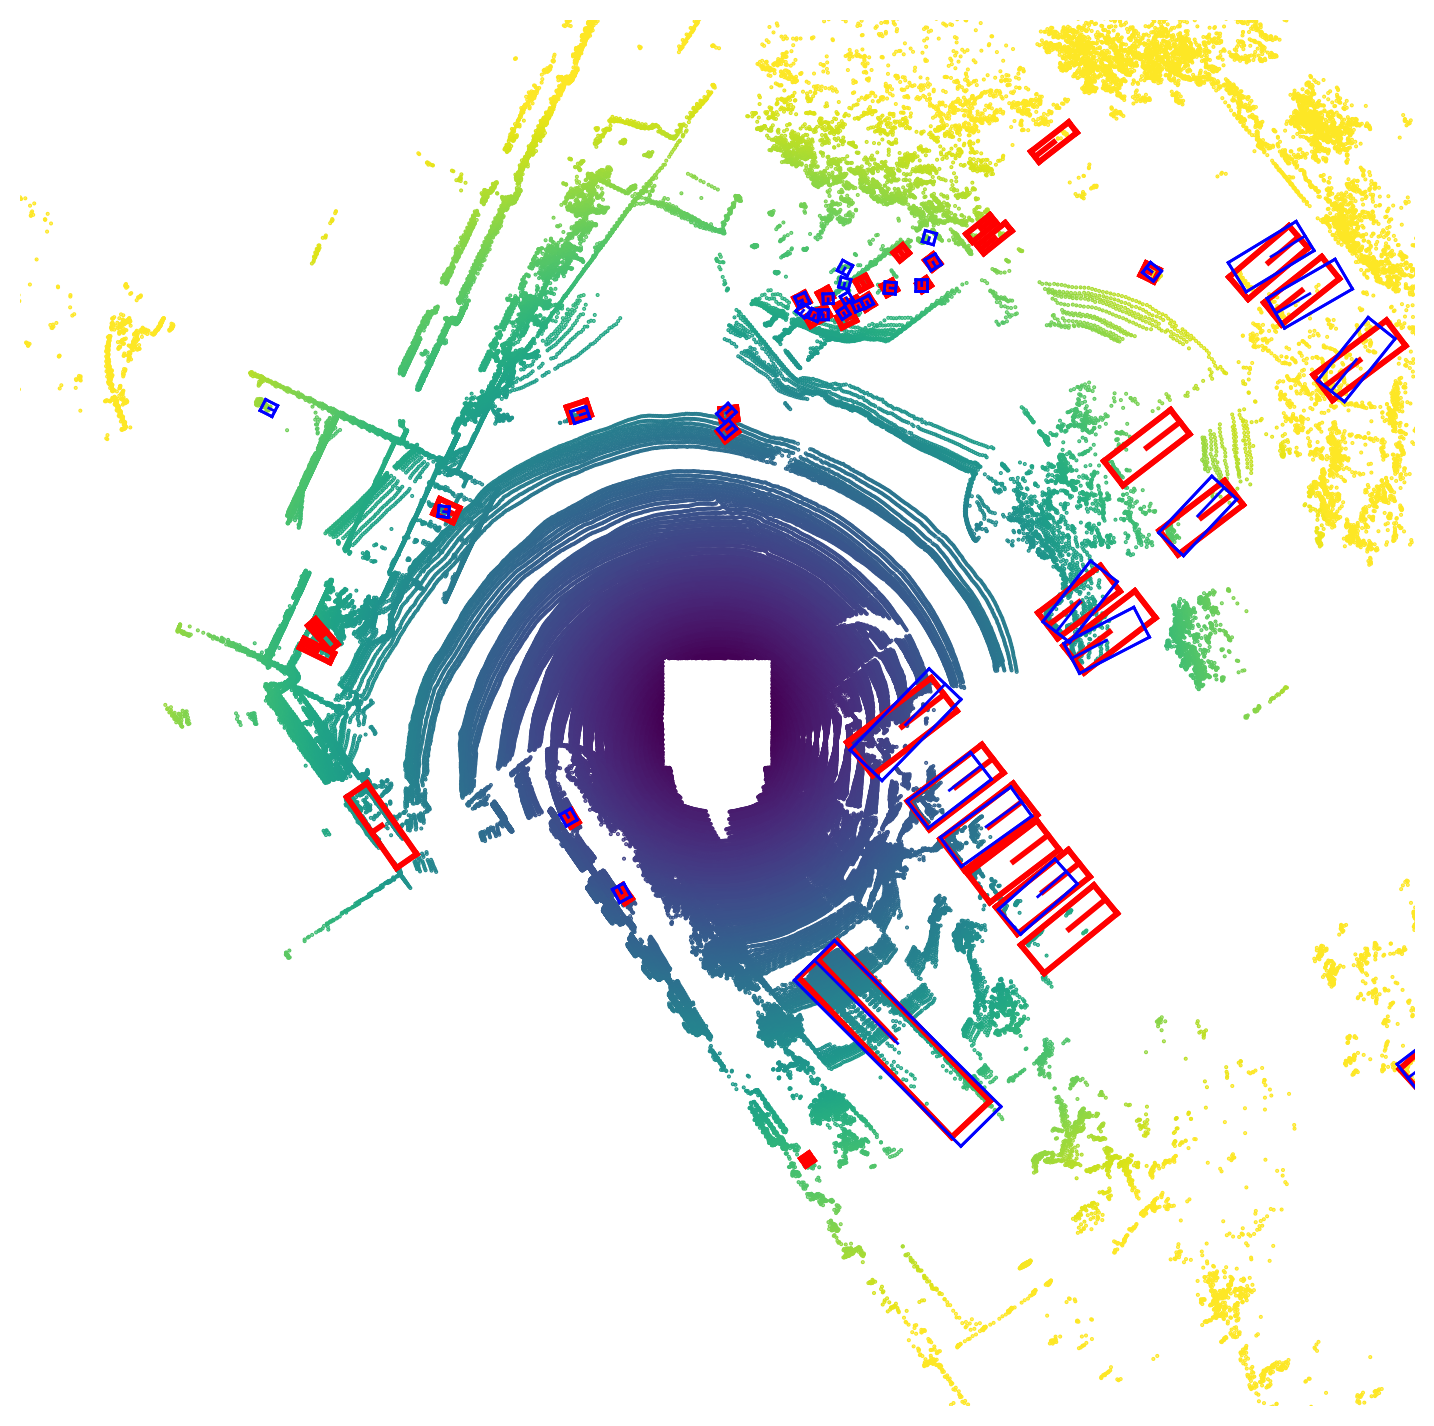

In [ ]:
vis_num = 1
draw_num = min(vis_num, len(token_list))
save_path = os.path.join(onnx_work_dir, "visual")
for token in random.sample(token_list, draw_num):
    print(token)
    visual(
        copy.deepcopy(points_dict[token]),
        copy.deepcopy(gt_annos_dict[token]),
        copy.deepcopy(detections[token]),
        token, save_path=None
    )

### evaluation

In [ ]:
all_predictions = all_gather(detections)

predictions = {}
for p in all_predictions:
    predictions.update(p)

result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=onnx_work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.7 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/demo-mini/onnx/infos_val_10sweeps_withvelo_filter_True.json
Initializing nuScenes detection evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/demo-mini/onnx/infos_val_10sweeps_withvelo_filter_True.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 376.43it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 16319
=> After distance based filtering: 13485
=> After LIDAR points based filtering: 13485
=> After bike rack filtering: 13428
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Rendering sample token b6c420c3a5bd4a219b1cb82ee5ea0aa7
Rendering sample token b22fa0b3c34f47b6a360b60f35d5d567
Rendering sample token d8251bbc2105497ab8ec80827d4429aa
Rendering sample token 372725a4b00e49c78d6d0b1c4a38b6e0
Rendering sample token ce94ef7a0522468e81c0e2b3a2f1e12d
Rendering sample token 0d0700a2284e477db876c3ee1d864668
Rendering sample token 61a7bd24f88a46c2963280d8b13ac675
Rendering sample token fa65a298c01f44e7a182bbf9e5fe3697
Rendering sample token 8573a885a7cb41d185c05029eeb9a54e
Rendering sample token 38a28a3aaf2647f2a8c0e90e31267bf8
Accumulating metric data.

## OM Model

### val-mini

In [5]:
import pickle

om_work_dir = "work_dirs/centerpoint_pillar_pretrain/val-mini/om"

results_dir = os.path.join(om_work_dir, "predictions")
results_list = glob.glob(os.path.join(results_dir, "prediction_*-*.pkl"))
predictions = {}
for result_path in results_list:    
    with open(result_path, "rb") as f:
        predictions.update(pickle.load(f))

print("number of predictions:", len(predictions))

for token, output in predictions.items():
    for k, v in output.items():
        if isinstance(v, np.ndarray):
            output[k] = torch.from_numpy(v)

dataset = build_dataset(cfg.data.val)
result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=om_work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

number of predictions: 81
10
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/val-mini/om/infos_val_10sweeps_withvelo_filter_True.json
Initializing nuScenes detection evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/val-mini/om/infos_val_10sweeps_withvelo_filter_True.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 332.74it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 16329
=> After distance based filtering: 13495
=> After LIDAR points based filtering: 13495
=> After bike rack filtering: 13437
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Rendering sample token b6c420c3a5bd4a219b1cb82ee5ea0aa7
Rendering sample token b22fa0b3c34f47b6a360b60f35d5d567
Rendering sample token d8251bbc2105497ab8ec80827d4429aa
Rendering sample token 372725a4b00e49c78d6d0b1c4a38b6e0
Rendering sample token ce94ef7a0522468e81c0e2b3a2f1e12d
Rendering sample token 0d0700a2284e477db876c3ee1d864668
Rendering sample token 61a7bd24f88a46c2963280d8b13ac675
Rendering sample token fa65a298c01f44e7a182bbf9e5fe3697
Rendering sample token 8573a885a7cb41d185c05029eeb9a54e
Rendering sample token 38a28a3aaf2647f2a8c0e90e31267bf8
Accumulating metric data.

### test

In [6]:
import pickle

om_work_dir = "work_dirs/centerpoint_pillar_pretrain/test/om"

results_dir = os.path.join(om_work_dir, "predictions")
results_list = glob.glob(os.path.join(results_dir, "prediction_*-*.pkl"))
predictions = {}
for result_path in results_list:    
    with open(result_path, "rb") as f:
        predictions.update(pickle.load(f))

print("number of predictions:", len(predictions))

for token, output in predictions.items():
    for k, v in output.items():
        if isinstance(v, np.ndarray):
            output[k] = torch.from_numpy(v)

dataset = build_dataset(cfg.data.test)
result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=om_work_dir, testset=True)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

number of predictions: 6008
10
Loading NuScenes tables for version v1.0-test...
23 category,
8 attribute,
4 visibility,
0 instance,
12 sensor,
1800 calibrated_sensor,
462901 ego_pose,
15 log,
150 scene,
6008 sample,
462901 sample_data,
0 sample_annotation,
4 map,
Done loading in 9.4 seconds.
Reverse indexing ...
Done reverse indexing in 1.3 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/test/om/infos_test_10sweeps_withvelo.json
